In [149]:
#!pip install vecstack
#!pip install pickle5

## Weather AUS Prediction

Prédire la pluie du lendemain en entraînant des modèles de classification sur la variable cible RainTomorrow.
Contenu

Ce jeu de données contient environ 10 ans d'observations météorologiques quotidiennes provenant de nombreux endroits en Australie.

Nous devons calculer les éléments suivants :

- Le nombre total de jours, 'n_days'.
- Le nombre de jours avec au moins 1mm ou plus de pluie, 'n_atleast_1mm'.
- Le nombre de jours avec moins de 1mm de pluie, 'n_lessthan_1mm'.
- Pourcentage de jours avec 1mm ou plus de pluie, 'rainy_days_percentage'.


## Analyse des variables du Dataset

- Date
La date de l'observation

- Location
Le nom commun de l'emplacement de la station météorologique.

- MinTemp
La température minimale en degrés Celsius

- MaxTemp
La température maximale en degrés Celsius

- Rainfall
La quantité de pluie enregistrée pour la journée, en mm.

- Evaporation
L'évaporation de la casserole de classe A (mm) dans les 24 heures jusqu'à 9 heures du matin.

- Sunshine
Le nombre d'heures d'ensoleillement dans la journée.

- WindGustDir
La direction de la plus forte rafale de vent dans les 24 heures jusqu'à minuit.

- WindGustSpeed
La vitesse (km/h) de la plus forte rafale de vent au cours des 24 heures précédant minuit.

- WindDir9am
Direction du vent à 9h du matin

- WindDir3pm
Direction du vent à 15h

- WindSpeed9am
Vitesse du vent (km/h) moyennée sur 10 minutes avant 9h.

- WindSpeed3pm
Vitesse du vent (km/h) moyenne sur 10 minutes avant 15h00

- Humidity9h
Humidité (pourcentage) à 9h du matin

- Humidity3pm
Humidité (pourcentage) à 15h

- Pression9am
Pression atmosphérique (hpa) ramenée au niveau moyen de la mer à 9h00

- Pressure3pm 
Pression atmosphérique (hpa) ramenée au niveau moyen de la mer à 15h.

- Nuage9am
Fraction du ciel obscurcie par les nuages à 9h du matin. Elle est mesurée en "oktas", qui sont une unité de huitièmes. Elle indique combien de huitièmes du ciel sont obscurcis par les nuages. Une mesure de 0 indique un ciel complètement dégagé tandis qu'une mesure de 8 indique un ciel complètement couvert.

- Nuage3pm
Fraction du ciel obscurcie par les nuages (en "oktas" : huitièmes) à 15 heures. Voir Cload9am pour une description des valeurs.

- Temp9am
Température (degrés C) à 9h du matin

- Temp3pm
Température (degrés C) à 15h

- RainToday
Booléen : 1 si les précipitations (mm) dans les 24 heures jusqu'à 9 heures dépassent 1mm, sinon 0.

- RainTomorrow
La quantité de pluie prévue pour le lendemain, en mm. Utilisée pour créer la variable de réponse RainTomorrow. Une sorte de mesure du "risque".



In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from vecstack import StackingTransformer
from statsmodels.regression.linear_model import OLS
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import pickle5 as pickle

In [7]:
def remove_columns(df, cln):
  df.drop(columns=[cln],inplace=True)

In [8]:
def Label(df, cln):
  le = LabelEncoder()
  df[cln] = le.fit_transform(df[cln])

In [103]:
# Scoreur
def rmsle(y, y0,n=2):
  assert len(y) == len(y0)
  return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0), n)))

In [151]:
def Label(df, cln):
    le = LabelEncoder()
    df[cln] = le.fit_transform(df[cln])

In [177]:
def calculate_result(df, cln):
    no = 0
    yes = 0
    for w in df.index: # pour tous les index du data frame
        if df['Predictions'][w] == 0:
            no=no+1
        elif df['Predictions'][w] == 1:
            yes=yes+1
    print("Number of occurence of no ", no)
    print("Number of occurence of yes ", yes)

In [11]:
training_set = pd.read_csv('./datasets/weatherAUS_train.csv', sep=',')
submission_set = pd.read_csv('./datasets/weatherAUS_submission.csv', sep=',')

In [12]:
training_set.dtypes
# submission_set.dtypes

Unnamed: 0         int64
Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object

In [13]:
# Remove the Unnamed colums
training_set = training_set[training_set.columns.drop(list(training_set.filter(regex='Unnamed')))]
 
training_set = training_set[training_set.columns.drop(list(training_set.filter(regex='Cloud')))]

training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           1300 non-null   object 
 1   Location       1300 non-null   object 
 2   MinTemp        1292 non-null   float64
 3   MaxTemp        1292 non-null   float64
 4   Rainfall       1286 non-null   float64
 5   Evaporation    0 non-null      float64
 6   Sunshine       0 non-null      float64
 7   WindGustDir    1279 non-null   object 
 8   WindGustSpeed  1279 non-null   float64
 9   WindDir9am     1047 non-null   object 
 10  WindDir3pm     1269 non-null   object 
 11  WindSpeed9am   1294 non-null   float64
 12  WindSpeed3pm   1291 non-null   float64
 13  Humidity9am    1297 non-null   float64
 14  Humidity3pm    1294 non-null   float64
 15  Pressure9am    1297 non-null   float64
 16  Pressure3pm    1294 non-null   float64
 17  Temp9am        1297 non-null   float64
 18  Temp3pm 

In [14]:
# Extracting Needed Columns
training_set = training_set[['MinTemp', 'MaxTemp','Temp3pm','WindGustSpeed','WindSpeed9am', 'Rainfall','WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'RainTomorrow']].reset_index(drop=True)

In [15]:
training_set.describe()

,MinTemp,MaxTemp,Temp3pm,WindGustSpeed,WindSpeed9am,Rainfall,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm
count,1292.000000,1292.000000,1294.000000,1279.000000,1294.000000,1286.000000,1291.000000,1297.000000,1294.000000,1297.000000,1294.000000
mean,9.584752,22.368885,21.189645,33.043784,8.121329,2.219285,14.075910,74.287587,48.455178,1018.042945,1015.455796
std,6.262595,7.659134,7.421684,13.825979,6.904606,7.435475,7.286526,17.306419,19.476579,7.311087,7.102400
min,-2.500000,8.200000,7.300000,11.000000,0.000000,0.000000,0.000000,20.000000,7.000000,989.800000,982.900000
25%,4.400000,15.700000,14.800000,24.000000,2.000000,0.000000,9.000000,61.000000,35.000000,1012.900000,1010.300000
50%,9.300000,21.900000,20.600000,31.000000,7.000000,0.000000,13.000000,77.000000,48.000000,1018.100000,1015.500000
75%,14.600000,28.400000,26.800000,41.000000,11.000000,0.600000,19.000000,88.000000,60.000000,1023.000000,1020.300000
max,28.300000,44.800000,43.400000,107.000000,37.000000,104.200000,50.000000,100.000000,100.000000,1039.900000,1036.000000


In [16]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MinTemp        1292 non-null   float64
 1   MaxTemp        1292 non-null   float64
 2   Temp3pm        1294 non-null   float64
 3   WindGustSpeed  1279 non-null   float64
 4   WindSpeed9am   1294 non-null   float64
 5   Rainfall       1286 non-null   float64
 6   WindSpeed3pm   1291 non-null   float64
 7   Humidity9am    1297 non-null   float64
 8   Humidity3pm    1294 non-null   float64
 9   Pressure9am    1297 non-null   float64
 10  Pressure3pm    1294 non-null   float64
 11  RainTomorrow   1286 non-null   object 
dtypes: float64(11), object(1)
memory usage: 122.0+ KB


In [17]:
training_set.columns.unique()

Index(['MinTemp', 'MaxTemp', 'Temp3pm', 'WindGustSpeed', 'WindSpeed9am',
       'Rainfall', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'RainTomorrow'],
      dtype='object')

In [18]:
# Replace na by median
training_set = training_set.apply(lambda x: x.fillna(x.median()) if x.dtype == 'float' else x.fillna(x.value_counts().index[0]))

In [19]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MinTemp        1300 non-null   float64
 1   MaxTemp        1300 non-null   float64
 2   Temp3pm        1300 non-null   float64
 3   WindGustSpeed  1300 non-null   float64
 4   WindSpeed9am   1300 non-null   float64
 5   Rainfall       1300 non-null   float64
 6   WindSpeed3pm   1300 non-null   float64
 7   Humidity9am    1300 non-null   float64
 8   Humidity3pm    1300 non-null   float64
 9   Pressure9am    1300 non-null   float64
 10  Pressure3pm    1300 non-null   float64
 11  RainTomorrow   1300 non-null   object 
dtypes: float64(11), object(1)
memory usage: 122.0+ KB


In [20]:
#  transform RainTomorrow into a quantitative variables (1-0)
training_set.RainTomorrow.replace(('Yes', 'No'), (1, 0), inplace=True)

<AxesSubplot:>

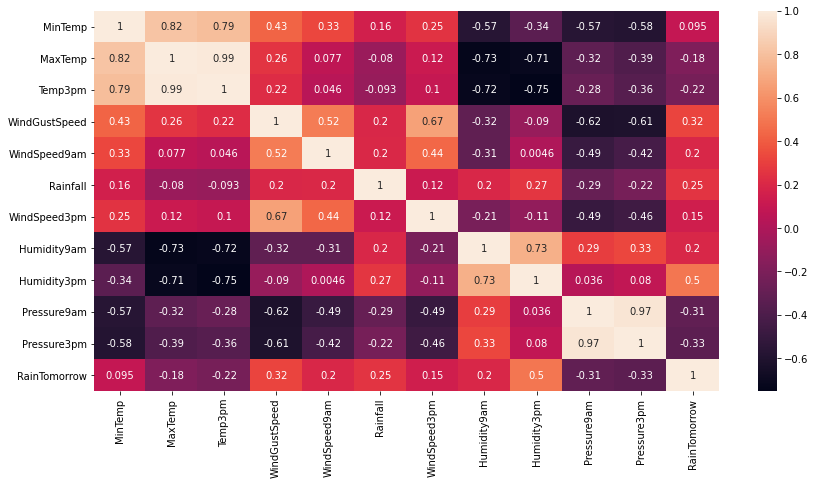

In [21]:
## Corrlation matrix
plt.figure(
  figsize=(14,7))

sns.heatmap(
  training_set.corr(),
  annot = True
)

In [22]:
training_set.count().sort_values()

MinTemp          1300
MaxTemp          1300
Temp3pm          1300
WindGustSpeed    1300
WindSpeed9am     1300
Rainfall         1300
WindSpeed3pm     1300
Humidity9am      1300
Humidity3pm      1300
Pressure9am      1300
Pressure3pm      1300
RainTomorrow     1300
dtype: int64

In [23]:
training_set

,MinTemp,MaxTemp,Temp3pm,WindGustSpeed,WindSpeed9am,Rainfall,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,RainTomorrow
0,13.4,22.9,21.8,44.0,20.0,0.6,24.0,71.0,22.0,1007.7,1007.1,0
1,7.4,25.1,24.3,44.0,4.0,0.0,22.0,44.0,25.0,1010.6,1007.8,0
2,12.9,25.7,23.2,46.0,19.0,0.0,26.0,38.0,30.0,1007.6,1008.7,0
3,9.2,28.0,26.5,24.0,11.0,0.0,9.0,45.0,16.0,1017.6,1012.8,0
4,17.5,32.3,29.7,41.0,7.0,1.0,20.0,82.0,33.0,1010.8,1006.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1295,7.7,15.3,11.9,39.0,4.0,0.0,19.0,84.0,69.0,1020.7,1017.8,0
1296,-0.8,12.7,11.1,24.0,0.0,0.6,17.0,100.0,58.0,1024.5,1023.2,0
1297,2.3,15.3,13.7,31.0,0.0,0.0,17.0,86.0,67.0,1028.7,1027.3,0
1298,1.4,15.3,14.8,15.0,2.0,0.0,7.0,100.0,53.0,1033.1,1030.3,0


In [24]:
var_cat = training_set.select_dtypes(include='object').columns #these are the categorical columns
var_cat

Index([], dtype='object')

In [25]:
feat_list = training_set.columns[~training_set.columns.isin(training_set.columns[7:8])].tolist()
features = training_set[feat_list]
labels = training_set['RainTomorrow']

In [26]:
# Total number of days
number_of_days = len(training_set)

# The number of days with atleast 1mm or more of rain
n_atleast_1mm = training_set[training_set['Rainfall'] >= 1.0].count()[4]

# The number of days with less than 1mm of rain
n_lessthan_1mm = training_set[training_set['Rainfall'] < 1.0].count()[4]

# Percentage of days with 1mm or more than 1mm of rain
rainy_days_percentage= (float(n_atleast_1mm) * 100/ float(number_of_days))

print("Number of days:", number_of_days)
print("Number of days with atleast 1mm or more of rain:", n_atleast_1mm)
print("Nmber of days with less than 1mm of rain:", n_lessthan_1mm)
print("Percentage of days with 1mm or more than 1mm of rain:", rainy_days_percentage)

Number of days: 1300
Number of days with atleast 1mm or more of rain: 295
Nmber of days with less than 1mm of rain: 1005
Percentage of days with 1mm or more than 1mm of rain: 22.692307692307693


In [27]:
# Verifing ig we have null values on the dataframe
training_set.isnull().values.any()
training_set.isnull().sum()

MinTemp          0
MaxTemp          0
Temp3pm          0
WindGustSpeed    0
WindSpeed9am     0
Rainfall         0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
RainTomorrow     0
dtype: int64

In [28]:
training_set_cp = training_set.copy()

In [117]:
# Scaler = MinMaxScaler()
# features_min_max = pd.DataFrame(training_set=training_set)
# features_min_max[feat_list] = Scaler.fit_transform(training_set[feat_list])
y = training_set_cp['RainTomorrow']
X = training_set_cp.drop('RainTomorrow',axis=1)

In [118]:
X

,MinTemp,MaxTemp,Temp3pm,WindGustSpeed,WindSpeed9am,Rainfall,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm
0,13.4,22.9,21.8,44.0,20.0,0.6,24.0,71.0,22.0,1007.7,1007.1
1,7.4,25.1,24.3,44.0,4.0,0.0,22.0,44.0,25.0,1010.6,1007.8
2,12.9,25.7,23.2,46.0,19.0,0.0,26.0,38.0,30.0,1007.6,1008.7
3,9.2,28.0,26.5,24.0,11.0,0.0,9.0,45.0,16.0,1017.6,1012.8
4,17.5,32.3,29.7,41.0,7.0,1.0,20.0,82.0,33.0,1010.8,1006.0
...,...,...,...,...,...,...,...,...,...,...,...
1295,7.7,15.3,11.9,39.0,4.0,0.0,19.0,84.0,69.0,1020.7,1017.8
1296,-0.8,12.7,11.1,24.0,0.0,0.6,17.0,100.0,58.0,1024.5,1023.2
1297,2.3,15.3,13.7,31.0,0.0,0.0,17.0,86.0,67.0,1028.7,1027.3
1298,1.4,15.3,14.8,15.0,2.0,0.0,7.0,100.0,53.0,1033.1,1030.3


In [122]:
#  feature_series = pd.Series(training_set, index=training_set.columns).sort_values(ascending=False)

## Datavizualisation

In [ ]:
# Showing features

# plt.figure(figsize=(10, 6))
# sns.barplot(x=features, y=features.index)

# plt.xlabel('Features importnace score')
# plt.ylabel('Features')
# plt.title('Features visualization')

# plt.tight_layout()



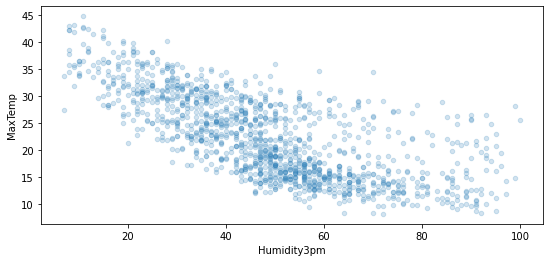

In [32]:
# Regression lineaire simple
ax = training_set.plot(kind='scatter', x='Humidity3pm', y='MaxTemp', alpha=0.2, figsize=(9,4))

In [ ]:
#How to read our model (insight step 2)
%matplotlib inline
model = pipeline.named_steps['model']
print(model.feature_importances_[:10])

importances3 = model.feature_importances_[:10]
indices3 = np.argsort(importances3)
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices3)), importances3[indices3], color='b', align='center')
plt.yticks(range(len(indices3)), features)
plt.xlabel('Relative Importance')

## Application des modèles

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(training_set, y, test_size=0.2, random_state=0)

In [123]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2, random_state = 0)

In [124]:
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 1040 samples.
Testing set has 260 samples.


In [125]:
pd.DataFrame(X_test).describe()

,MinTemp,MaxTemp,Temp3pm,WindGustSpeed,WindSpeed9am,Rainfall,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm
count,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000
mean,9.421154,22.659615,21.513077,32.969231,7.761538,1.810769,13.696154,74.384615,48.323077,1018.471923,1015.679231
std,6.543774,7.858234,7.579931,14.645325,6.416441,5.282348,7.588092,17.496336,19.729333,7.490536,7.410190
min,-2.000000,9.600000,8.700000,11.000000,0.000000,0.000000,0.000000,33.000000,8.000000,1000.500000,997.800000
25%,3.675000,15.700000,14.875000,22.000000,2.000000,0.000000,9.000000,60.000000,35.000000,1013.150000,1009.850000
50%,9.100000,22.300000,21.150000,31.000000,7.000000,0.000000,13.000000,78.000000,48.000000,1018.350000,1015.350000
75%,14.800000,28.475000,26.725000,43.000000,11.000000,0.200000,19.000000,88.000000,60.000000,1024.000000,1020.950000
max,24.700000,42.700000,42.000000,107.000000,26.000000,52.200000,50.000000,100.000000,97.000000,1036.600000,1033.300000


In [74]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)
#X_train = np.nan_to_num(X_train)
#y_train = np.nan_to_num(y_train)

In [ ]:
n_estimators = [100, 200, 300]
max_depth = [1, 2, 5]
min_samples_split = [2, 3, 5]
min_samples_leaf = [1, 2, 3] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(RF1, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train)

## Random Forest Modèle

In [49]:
model_rf = RandomForestClassifier()

model_rf.fit(X_train,y_train)

y_pred_test = model_rf.predict(X_test)

# View accuracy score
print("Accuracy model on training : {:.3f}".format(accuracy_score(y_test, y_pred_test)))

Accuracy model on training : 0.858


## Logistic Regression modèle

In [60]:
## Logistic Regrssion

# We defining the model
logreg = LogisticRegression(C=10)

# We train the model
logreg.fit(X_train, y_train)

Y_pred_logreg_train = logreg.predict(X_train)
# We predict target values
Y_predict_logreg = logreg.predict(X_test)

print("Logistic Regrssion Accuracy: {:.3f}".format(accuracy_score(y_test, Y_predict_logreg)))

Logistic Regrssion Accuracy: 0.915


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## XGBC Boosting Classifier modèle

In [52]:
clf = XGBClassifier()

#Parameters
parameters =  {
    'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [6],
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [5], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [1337]
}


# scorer = make_scorer(fbeta_score,beta=0.5)

grid_obj = GridSearchCV(clf, parameters, verbose = 1, 
                      n_jobs = -1)

grid_fit = grid_obj.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[15:58:37] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:58:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [63]:
print(rmsle(y_test, Y_predict_logreg))

0.20162766814678323


In [64]:
reg_scorer = make_scorer(rmsle)
reg_scorer

make_scorer(rmsle)

In [66]:
# We got a great results with these models
# Now we need to Tuning params of their models with GridSearch

model_randomForest = RandomForestClassifier(random_state=0)
model_logReg = LogisticRegression(C=10)
model_clf = XGBClassifier()


models = [
    model_logReg,
    model_randomForest,
    model_clf
]

param_grid_logReg = {
    "C": np.logspace(-3,3,7), 
    "penalty": ["l1","l2"]
}

param_grid_rf = {
    'bootstrap': [True],
    'max_depth': [1, 2, 5],
    'max_features': ['sqrt'],
    'min_samples_leaf': [4, 5, 6],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [350, 400, 450]
}

param_grid_clf =  {
    'nthread': [4], #when use hyperthread, xgboost may become slower
    'objective': ['binary:logistic'],
    'learning_rate': [0.05], #so called `eta` value
    'max_depth': [6],
    'min_child_weight': [11],
    'silent': [1],
    'subsample': [0.8],
    'colsample_bytree': [0.7],
    'n_estimators': [5], #number of trees, change it to 1000 for better results
    'missing': [-999],
    'seed': [1337]
}

params = [param_grid_logReg,  param_grid_rf, param_grid_clf ]
stock = []

for model, p in zip(models, params):
    model_name = model.__class__.__name__
    modell = GridSearchCV(estimator=model, param_grid=p, n_jobs=1, cv=10, scoring=reg_scorer)
    modell.fit(X_train, y_train)
    print(str(model_name) + ' classification...')
    print('Best Params:')
    print(modell.best_params_)
    y_pred = modell.predict(X_test)
    print('RMSLE: '), 
    print(rmsle(y_test, y_pred))
    stock.append((model_name, modell.best_params_, rmsle(y_test, y_pred)))
    
final_df = pd.DataFrame(stock, columns=['model_name', 'Best_params', 'rmsle'])   


#return final_df, stock

/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: Fi

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

LogisticRegression regression...
Best Params:
{'C': 0.001, 'penalty': 'l2'}
RMSLE: 
0.24694245249341804
RandomForestClassifier regression...
Best Params:
{'bootstrap': True, 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 350}
RMSLE: 
0.2978238035384839
[18:03:40] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:03:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:03:40] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate

/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder i

SyntaxError: 'return' outside function (<ipython-input-66-890ba1470a4f>, line 61)

In [88]:
#final_df['Best_params'][0]
#final_df['Best_params'][1]
final_df['Best_params'][2]

{'colsample_bytree': 0.7,
 'learning_rate': 0.05,
 'max_depth': 6,
 'min_child_weight': 11,
 'missing': -999,
 'n_estimators': 5,
 'nthread': 4,
 'objective': 'binary:logistic',
 'seed': 1337,
 'silent': 1,
 'subsample': 0.8}

In [98]:
models = [
    ('lg', LogisticRegression(C=0.001, penalty='l2')),
        
    ('rf', RandomForestClassifier(bootstrap=True, max_depth=1, max_features='sqrt', min_samples_leaf=4, min_samples_split=8,n_estimators=350)),
    
    ('xgbc', XGBClassifier(colsample_bytree=0.7,
                learning_rate=0.05,
                max_depth=6,
                n_estimators = 5,
                min_child_weight=11,
                missing=-999,
                nthread=4,
                objective='binary:logistic',
                seed=1337, 
                silent=1,
                subsample=0.8
            )
    )
]

In [136]:
%%time
stack = StackingTransformer(
    estimators=models,          # base estimators
    needs_proba=False,
    metric=accuracy_score, 
    n_folds=4, 
    stratified=True,
    shuffle=True,
    random_state=0,    
    verbose=2
)   

CPU times: user 0 ns, sys: 16 µs, total: 16 µs
Wall time: 31 µs


In [139]:
final_estimator = XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, n_estimators=100, max_depth=3)

In [140]:
steps = [('stack', stack), ('final_estimator', final_estimator)]

# Init Pipeline
pipe = Pipeline(steps)

In [142]:
pipe = pipe.fit(X_train, y_train)

# Predict
y_pred_pipe = pipe.predict(X_test)

task:         [regression]
metric:       [accuracy_score]
variant:      [A]
n_estimators: [3]

estimator  0: [lg: LogisticRegression]
    fold  0:  [0.89230769]
    fold  1:  [0.86153846]
    fold  2:  [0.83076923]
    fold  3:  [0.90000000]
    ----
    MEAN:     [0.87115385] + [0.02739963]

estimator  1: [rf: RandomForestClassifier]


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

    fold  0:  [0.79230769]
    fold  1:  [0.77692308]
    fold  2:  [0.75769231]
    fold  3:  [0.83846154]
    ----
    MEAN:     [0.79134615] + [0.02983869]

estimator  2: [xgbc: XGBClassifier]
[20:06:00] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:06:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
    fold  0:  [0.84615385]
[20:06:00] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoos

/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder i

    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE

estimator  2: [xgbc: XGBClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE

[20:06:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Transforming...

estimator  0: [lg: LogisticRegression]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE

estimator  1: [rf: RandomForestClassifier]


/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE

estimator  2: [xgbc: XGBClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE



In [146]:
print('Final prediction score using Pipeline: [%.3f]' % accuracy_score(y_test, y_pred_pipe))

Final prediction score using Pipeline: [0.869]


In [ ]:
# Nettoyage du dataset Submission
submission_set = submission_set[submission_set.columns.drop(list(submission_set.filter(regex='Unnamed')))]
remove_columns(submission_set,"Sunshine")
remove_columns(submission_set,"Evaporation")
remove_columns(submission_set,"Cloud9am")
remove_columns(submission_set,"Cloud3pm")
remove_columns(submission_set,"Date")
remove_columns(submission_set,"Location")
Label(submission_set, 'WindGustDir')
Label(submission_set, 'WindDir9am')
Label(submission_set, 'WindDir3pm')
Label(submission_set, 'RainToday')

In [158]:
submission_set = submission_set.apply(lambda x: x.fillna(x.median()) if x.dtype == 'float' else x.fillna(x.value_counts().index[0]))

In [163]:
submission_set = submission_set[['MinTemp', 'MaxTemp','Temp3pm','WindGustSpeed','WindSpeed9am', 'Rainfall','WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm']].reset_index(drop=True)

In [164]:
submission_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144160 entries, 0 to 144159
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   MinTemp        144160 non-null  float64
 1   MaxTemp        144160 non-null  float64
 2   Temp3pm        144160 non-null  float64
 3   WindGustSpeed  144160 non-null  float64
 4   WindSpeed9am   144160 non-null  float64
 5   Rainfall       144160 non-null  float64
 6   WindSpeed3pm   144160 non-null  float64
 7   Humidity9am    144160 non-null  float64
 8   Humidity3pm    144160 non-null  float64
 9   Pressure9am    144160 non-null  float64
 10  Pressure3pm    144160 non-null  float64
dtypes: float64(11)
memory usage: 12.1 MB


In [161]:
%%time
# save the model to disk
filename1 = 'pipe_model.sav'
pickle.dump(pipe, open(filename1, 'wb'), protocol=4)

CPU times: user 101 ms, sys: 7.11 ms, total: 108 ms
Wall time: 107 ms


In [171]:
filename1 = 'pipe_model.sav'
model = pickle.load(open(filename1, 'rb'))

# Predict
y_prediction = model.predict(submission_set)

Submission = pd.DataFrame(y_prediction, columns = ['Predictions'])

Transforming...

estimator  0: [lg: LogisticRegression]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE

estimator  1: [rf: RandomForestClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE

estimator  2: [xgbc: XGBClassifier]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    ----
    DONE



In [178]:
calculate_result(Submission, 'Predictions')

Number of occurence of no  98829
Number of occurence of yes  45331


In [179]:
weatherAus = submission_set.join(Submission)
weatherAus.to_csv('WeatherAUS_Prediction.csv',sep=",")

In [181]:
# Transform predicted values to Yes - No
weatherAus.Predictions.replace((1, 0),('Yes', 'No'),inplace=True)

In [182]:
weatherAus

,MinTemp,MaxTemp,Temp3pm,WindGustSpeed,WindSpeed9am,Rainfall,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Predictions
0,-0.1,16.1,15.5,13.0,0.0,0.0,4.0,100.0,49.0,1032.3,1028.3,No
1,0.4,13.6,13.2,15.0,0.0,0.0,7.0,100.0,66.0,1029.3,1025.5,No
2,2.9,14.6,14.1,28.0,0.0,0.0,13.0,94.0,64.0,1021.9,1016.8,No
3,7.0,14.8,14.4,37.0,11.0,2.4,15.0,91.0,55.0,1013.0,1010.8,No
4,6.7,11.5,10.3,17.0,9.0,6.2,9.0,96.0,86.0,1013.2,1012.3,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...
144155,2.8,23.4,22.4,31.0,13.0,0.0,11.0,51.0,24.0,1024.6,1020.3,No
144156,3.6,25.3,24.5,22.0,13.0,0.0,9.0,56.0,21.0,1023.5,1019.1,No
144157,5.4,26.9,26.1,37.0,9.0,0.0,9.0,53.0,24.0,1021.0,1016.8,No
144158,7.8,27.0,26.0,28.0,13.0,0.0,7.0,51.0,24.0,1019.4,1016.5,No
